In [ ]:
!pip install sdeint

  Preparing metadata (setup.py) ... done
  Created wheel for sdeint: filename=sdeint-0.3.0-py3-none-any.whl size=25904 sha256=9227e30259f6ebd5988feb52c3ee3151ba25be0920ea2ba2eb9210f46966132a
  Stored in directory: /root/.cache/pip/wheels/f9/85/bb/4d274a94104fc3050d1652321aeb6d18b48b9e3cf752a8b32d
Successfully built sdeint


In [1]:
!pip3 install polygon-api-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.5/162.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 13.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7
  Attempting uninstall: certifi
    Found existing installation: certifi 2024.2.2
    Uninstalling certifi-2024.2.2:
      Successfully uninstalled certifi-2024.2.2


In [2]:
import polygon as polygon
import numpy as np
import datetime as dt
import pandas as pd


In [3]:
#client = polygon.StocksClient("qAECEY64BgfArsBJID6VYCJ1k0asFEll", True)
client = polygon.RESTClient(api_key="qAECEY64BgfArsBJID6VYCJ1k0asFEll", trace=False)
ticker = "AAPL"

# Hourly Intervals

In [55]:
def get_stock_data_to_df(ticker):
    aggs = []
    B = client.list_aggs(ticker=ticker, multiplier=1, timespan="hour", from_="2023-01-01", to="2023-06-13", limit=50000)
    # for a in B:
    #     aggs.append(a)
    # items = aggs
    data = []
    for item in B:
        # print(dir(item))
        data.append({
            "open": item.open,
            "high": item.high,
            "low": item.low,
            "close": item.close,
            "volume": item.volume,
            "vwap": item.vwap,
            "timestamp": item.timestamp,
            "transactions": item.transactions,

        })
    return pd.DataFrame(data)

In [56]:
def stationaryize(df : pd.DataFrame, time) -> pd.DataFrame:
    df['stationary'] = (np.log(df[time])).diff()
    df['timestamp_processed'] =  pd.to_datetime(df['timestamp'], unit='ms')
    df = df.dropna(how = 'any', axis = 0, )
    return df

def get_clean_data(ticker, open_or_close) -> pd.DataFrame:
    return stationaryize(get_stock_data_to_df(ticker.upper()), open_or_close)

In [57]:
aapl_df = get_clean_data("aapl", 'close')
aapl_df.head()

,open,high,low,close,volume,vwap,timestamp,transactions,stationary,timestamp_processed
1,131.40,131.4000,130.80,131.0000,42853.0,131.0004,1672740000000,1008,-0.002287,2023-01-03 10:00:00
2,130.91,131.2500,130.05,130.3800,84001.0,130.5171,1672743600000,1583,-0.004744,2023-01-03 11:00:00
3,130.38,130.7500,130.03,130.5000,184600.0,130.4379,1672747200000,3173,0.000920,2023-01-03 12:00:00
4,130.25,131.2285,129.63,130.9200,504693.0,130.6148,1672750800000,7436,0.003213,2023-01-03 13:00:00
5,130.95,131.3600,126.88,126.9336,15817380.0,129.4057,1672754400000,195835,-0.030922,2023-01-03 14:00:00


In [58]:
from polygon.rest.models import (
    TickerNews,
)

In [59]:
# pull dates of all news events for AAPL

news = []
for n in client.list_ticker_news("AAPL", order="desc", limit=1000):
    news.append(n)
#print(news[:5])
times = []
for index, item in enumerate(news):
    # verify this is an agg
    if isinstance(item, TickerNews):
        times.append(item.published_utc)

print(len(times))
print(times[len(times)-5:])
print(times[:5])

16640
['2018-11-25T15:00:00Z', '2018-11-18T15:00:00Z', '2018-11-12T16:11:00Z', '2018-11-05T22:50:00Z', '2017-04-10T00:24:00Z']
['2024-02-26T20:17:00Z', '2024-02-26T18:59:00Z', '2024-02-26T15:59:00Z', '2024-02-26T15:15:00Z', '2024-02-26T14:48:00Z']


In [60]:
from datetime import datetime

In [61]:
news_times_processed = []

for index, time in enumerate(times):
  time_exact = datetime.strptime(time, '%Y-%m-%dT%H:%M:%SZ')
  # process into hourly data
  news_times_processed.append(time_exact.replace(minute=0, second=0, microsecond=0))

news_times_processed[:5]

[datetime.datetime(2024, 2, 26, 20, 0),
 datetime.datetime(2024, 2, 26, 18, 0),
 datetime.datetime(2024, 2, 26, 15, 0),
 datetime.datetime(2024, 2, 26, 15, 0),
 datetime.datetime(2024, 2, 26, 14, 0)]

In [62]:
# pull trading volumes for option
aggs = []
for a in client.list_aggs(
    "AAPL",
    1,
    "hour",
    "2023-01-01",
    "2023-06-13",
    limit=50000,
):
    aggs.append(a)

#print(aggs)

ticker_times = []
volumes = []


for index, item in enumerate(aggs):
    my_ms = item.timestamp
    ticker_times.append(datetime.fromtimestamp(my_ms / 1000))
    volumes.append(item.volume)


print(ticker_times[len(ticker_times)-5:])
print(volumes[len(volumes)-5:])


[datetime.datetime(2023, 6, 13, 19, 0), datetime.datetime(2023, 6, 13, 20, 0), datetime.datetime(2023, 6, 13, 21, 0), datetime.datetime(2023, 6, 13, 22, 0), datetime.datetime(2023, 6, 13, 23, 0)]
[6555794.0, 3174829.0, 42935, 22639, 41720]


In [63]:
# create a DF that has: hour, volume, news/no news
# dates, volumes, and then check news

news_dates = []
for ticker_time in ticker_times:
  if ticker_time in news_times_processed:
    news_dates.append(1)
  else:
    news_dates.append(0)

print(len(ticker_times))
print(len(news_dates))


1792
1792


In [64]:
dict = {'Date': ticker_times, 'Volume': volumes, 'News': news_dates}
df = pd.DataFrame(dict)
df.head(20)

,Date,Volume,News
0,2023-01-03 09:00:00,143683.0,0
1,2023-01-03 10:00:00,42853.0,1
2,2023-01-03 11:00:00,84001.0,1
3,2023-01-03 12:00:00,184600.0,1
4,2023-01-03 13:00:00,504693.0,1
5,2023-01-03 14:00:00,15817380.0,1
6,2023-01-03 15:00:00,20193122.0,0
7,2023-01-03 16:00:00,15240147.0,0
8,2023-01-03 17:00:00,9027657.0,1
9,2023-01-03 18:00:00,9459025.0,1


In [65]:

df["Average Trading Volume"] = df["Volume"].rolling(40).mean()
df["Volume STD"] = df["Volume"].rolling(40).std()
df["Signal"] = 1
df.loc[df["Volume"] > df["Average Trading Volume"] + df["Volume STD"], "Signal"] = 2
df.loc[df["Volume"] < df["Average Trading Volume"] + df["Volume STD"], "Signal"] = 0
df


,Date,Volume,News,Average Trading Volume,Volume STD,Signal
0,2023-01-03 09:00:00,143683.0,0,NaN,NaN,1
1,2023-01-03 10:00:00,42853.0,1,NaN,NaN,1
2,2023-01-03 11:00:00,84001.0,1,NaN,NaN,1
3,2023-01-03 12:00:00,184600.0,1,NaN,NaN,1
4,2023-01-03 13:00:00,504693.0,1,NaN,NaN,1
...,...,...,...,...,...,...
1787,2023-06-13 19:00:00,6555794.0,1,3354423.850,3.242773e+06,0
1788,2023-06-13 20:00:00,3174829.0,0,3427436.125,3.203828e+06,0
1789,2023-06-13 21:00:00,42935.0,1,3254200.125,3.194562e+06,0
1790,2023-06-13 22:00:00,22639.0,0,3063173.800,3.152303e+06,0


In [66]:

!pip3 install pyinform
import pyinform

sol = pyinform.transfer_entropy(df["News"], df["Signal"], k=3)

In [67]:
sol

0.020991912505803085

In [84]:
def significance(x, y, lag, n_shuffles, pdf_estimator=None, bins=None, bandwidth=None,  both=True):
        """
        Perform significance analysis on the hypothesis test of statistical causality, for both X(t)->Y(t)
        and Y(t)->X(t) directions

        Calculated using:  Assuming stationarity, we shuffle the time series to provide the null hypothesis.
                           The proportion of tests where TE > TE_shuffled gives the p-value significance level.
                           The amount by which the calculated TE is greater than the average shuffled TE, divided
                           by the standard deviation of the results, is the z-score significance level.

        Arguments:
            TE              -      (list)    Contains the transfer entropy in each direction, i.e. [TE_XY, TE_YX]
            endog           -      (string)  The endogenous variable in the TE analysis being significance tested (i.e. X or Y)
            exog            -      (string)  The exogenous variable in the TE analysis being significance tested (i.e. X or Y)
            pdf_estimator   -      (string)  The pdf_estimator used in the original TE analysis
            bins            -      (Dict of lists)  The bins used in the original TE analysis

            n_shuffles      -      (float) Number of times to shuffle the dataframe, destroyig temporality
            both            -      (Bool) Whether to shuffle both endog and exog variables (z-score) or just exog                                  variables (giving z*-score)
        Returns:
            p_value         -      Probablity of observing the result given the null hypothesis
            z_score         -      Number of Standard Deviations result is from mean (normalised)
        """

        TE = [pyinform.transfer_entropy(x, y, k=lag), pyinform.transfer_entropy(y, x, k=lag)]

        ## Prepare array for Transfer Entropy of each Shuffle
        shuffled_TEs = np.zeros(shape = (2,n_shuffles))

        ##
        if both is True:
            pass #TBC

        for i in range(n_shuffles):
                ## Perform Shuffle
                xi, yi = np.random.permutation(x), np.random.permutation(y)

                ## Calculate New TE
                TE_shuffled = [pyinform.transfer_entropy(xi, yi, k=lag), pyinform.transfer_entropy(yi, xi, k=lag)]
                shuffled_TEs[:,i] = TE_shuffled


        ## Calculate p-values for each direction
        p_values = (np.count_nonzero(TE[0] < shuffled_TEs[0,:]) /n_shuffles , \
                    np.count_nonzero(TE[1] < shuffled_TEs[1,:]) /n_shuffles)

        ## Calculate z-scores for each direction
        z_scores = ( ( TE[0] - np.mean(shuffled_TEs[0,:]) ) / np.std(shuffled_TEs[0,:]) , \
                     ( TE[1] - np.mean(shuffled_TEs[1,:]) ) / np.std(shuffled_TEs[1,:])  )

        TE_mean = ( np.mean(shuffled_TEs[0,:]), \
                     np.mean(shuffled_TEs[1,:]) )

        ## Return the self.DF value to the unshuffled case
        return TE, p_values, z_scores

metrics= significance(df["News"], df["Signal"],  3, 100)
labels = ["Transfer Entropy Scores", "P values", "Z scores"]
for metric, label in zip(metrics, labels):
  print(f"{label}: {metric}")


Transfer Entropy Scores: [0.020991912505803085, 0.011644482986595112]
P values: (0.0, 0.05)
Z scores: (2.9999730395629407, 1.8465613867109099)


# PyCausality Method (permutation importance)

In [77]:
!pip install PyCausality

  Using cached PyCausality-1.2.0-py3-none-any.whl (22 kB)
  Using cached python_dateutil-2.6.1-py2.py3-none-any.whl (194 kB)
  Using cached nose-1.3.7-py3-none-any.whl (154 kB)
INFO: pip is looking at multiple versions of pandas to determine which version is compatible with other requirements. This could take a while.
  Using cached pandas-2.2.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Using cached pandas-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Using cached pandas-2.1.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached pandas-2.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached pandas-2.1.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached pandas-2.1.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.3 MB)
  Using cached pandas-2.1.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.7 MB)
I

In [85]:
# make a dataframe of news events and signal

df_2 = df.drop(['Volume',
                'Average Trading Volume', 'Volume STD'], axis=1)
df_2

,Date,News,Signal
0,2023-01-03 09:00:00,0,1
1,2023-01-03 10:00:00,1,1
2,2023-01-03 11:00:00,1,1
3,2023-01-03 12:00:00,1,1
4,2023-01-03 13:00:00,1,1
...,...,...,...
1787,2023-06-13 19:00:00,1,0
1788,2023-06-13 20:00:00,0,0
1789,2023-06-13 21:00:00,1,0
1790,2023-06-13 22:00:00,0,0


In [76]:
import PyCausality as pc
from pc.TransferEntropy import *

ModuleNotFoundError: No module named 'PyCausality'

In [72]:
TE = TransferEntropy(   DF = DataFrame,
                        endog = 'News',     # Dependent Variable
                        exog = 'Signal',      # Independent Variable
                        lag = 3,
                        window_size = {'MS':6},
                        window_stride = {'W':2}
                        )

## Calculate TE using KDE
TE.nonlinear_TE(pdf_estimator = 'kernel', n_shuffles=100)

## Display TE_XY, TE_YX and significance values
print(TE.results)

NameError: name 'TransferEntropy' is not defined

# 15-minute intervals

In [17]:
def get_stock_data_to_df(ticker):
    aggs = []
    B = client.list_aggs(ticker=ticker, multiplier=1, timespan="minute", from_="2023-01-01", to="2023-06-13", limit=50000)
    # for a in B:
    #     aggs.append(a)
    # items = aggs
    data = []
    for item in B:
        # print(dir(item))
        data.append({
            "open": item.open,
            "high": item.high,
            "low": item.low,
            "close": item.close,
            "volume": item.volume,
            "vwap": item.vwap,
            "timestamp": item.timestamp,
            "transactions": item.transactions,

        })
    return pd.DataFrame(data)

In [18]:
def stationaryize(df : pd.DataFrame, time) -> pd.DataFrame:
    df['stationary'] = (np.log(df[time])).diff()
    df['timestamp_processed'] =  pd.to_datetime(df['timestamp'], unit='ms')
    df = df.dropna(how = 'any', axis = 0, )
    return df

def get_clean_data(ticker, open_or_close) -> pd.DataFrame:
    return stationaryize(get_stock_data_to_df(ticker.upper()), open_or_close)

In [19]:
from polygon.rest.models import (
    TickerNews,
)

In [20]:
# pull times of all news events for AAPL

news = []
for n in client.list_ticker_news("AAPL", order="desc", limit=1000):
    news.append(n)
#print(news[:5])
times = []
for index, item in enumerate(news):
    # verify this is an agg
    if isinstance(item, TickerNews):
        times.append(item.published_utc)

print(len(times))
print(times[len(times)-5:])
print(times[:5])

16640
['2018-11-25T15:00:00Z', '2018-11-18T15:00:00Z', '2018-11-12T16:11:00Z', '2018-11-05T22:50:00Z', '2017-04-10T00:24:00Z']
['2024-02-26T20:17:00Z', '2024-02-26T18:59:00Z', '2024-02-26T15:59:00Z', '2024-02-26T15:15:00Z', '2024-02-26T14:48:00Z']


In [21]:
from datetime import datetime

In [22]:
news_times_processed = []

for index, time in enumerate(times):
  time_exact = datetime.strptime(time, '%Y-%m-%dT%H:%M:%SZ')
  # process into 15-minute data
  news_times_processed.append(time_exact.replace(minute= int(time_exact.minute/15) * 15, second=0, microsecond=0))

news_times_processed[:5]

[datetime.datetime(2024, 2, 26, 20, 15),
 datetime.datetime(2024, 2, 26, 18, 45),
 datetime.datetime(2024, 2, 26, 15, 45),
 datetime.datetime(2024, 2, 26, 15, 15),
 datetime.datetime(2024, 2, 26, 14, 45)]

In [23]:
# pull trading volumes for option
aggs = []
for a in client.list_aggs(
    "AAPL",
    1,
    "minute",
    "2022-01-01",
    "2023-12-31",
    limit=50000,
):
    aggs.append(a)

#print(aggs)

ticker_times = []
volumes = []


for index, item in enumerate(aggs):
    my_ms = item.timestamp
    dt_from_ms = datetime.fromtimestamp(my_ms / 1000).replace(second=0, microsecond=0)
    if dt_from_ms.minute % 15 == 0:
      ticker_times.append(dt_from_ms)
      volumes.append(item.volume)


print(ticker_times[len(ticker_times)-5:])
print(ticker_times[:5])
print(volumes[len(volumes)-5:])


[datetime.datetime(2023, 12, 29, 22, 30), datetime.datetime(2023, 12, 29, 23, 0), datetime.datetime(2023, 12, 29, 23, 15), datetime.datetime(2023, 12, 29, 23, 30), datetime.datetime(2023, 12, 30, 0, 30)]
[datetime.datetime(2022, 1, 3, 9, 0), datetime.datetime(2022, 1, 3, 9, 15), datetime.datetime(2022, 1, 3, 9, 30), datetime.datetime(2022, 1, 3, 9, 45), datetime.datetime(2022, 1, 3, 10, 0)]
[624, 539, 146, 225, 303]


In [24]:
# create a DF that has: time, volume, news/no news
# dates, volumes, and then check news

news_dates = []
for ticker_time in ticker_times:
  if ticker_time in news_times_processed:
    news_dates.append(1)
  else:
    news_dates.append(0)

print(len(ticker_times))
print(len(news_dates))


26661
26661


In [25]:
dict = {'Date': ticker_times, 'Volume': volumes, 'News': news_dates}
df = pd.DataFrame(dict)
df.head(20)

,Date,Volume,News
0,2022-01-03 09:00:00,1118.0,0
1,2022-01-03 09:15:00,4820.0,0
2,2022-01-03 09:30:00,467.0,0
3,2022-01-03 09:45:00,1071.0,1
4,2022-01-03 10:00:00,480.0,1
5,2022-01-03 10:15:00,4141.0,0
6,2022-01-03 10:30:00,1095.0,0
7,2022-01-03 11:00:00,4045.0,1
8,2022-01-03 11:15:00,1548.0,1
9,2022-01-03 11:30:00,420.0,0


In [28]:

df["Average Trading Volume"] = df["Volume"].rolling(40).mean()
df["Volume STD"] = df["Volume"].rolling(40).std()
df["Signal"] = 1
df.loc[df["Volume"] > df["Average Trading Volume"] + df["Volume STD"], "Signal"] = 2
df.loc[df["Volume"] < df["Average Trading Volume"] + df["Volume STD"], "Signal"] = 0
df


,Date,Volume,News,Average Trading Volume,Volume STD,Signal
0,2022-01-03 09:00:00,1118.0,0,NaN,NaN,1
1,2022-01-03 09:15:00,4820.0,0,NaN,NaN,1
2,2022-01-03 09:30:00,467.0,0,NaN,NaN,1
3,2022-01-03 09:45:00,1071.0,1,NaN,NaN,1
4,2022-01-03 10:00:00,480.0,1,NaN,NaN,1
...,...,...,...,...,...,...
26656,2023-12-29 22:30:00,624.0,0,75197.775,128128.580741,0
26657,2023-12-29 23:00:00,539.0,0,75175.100,128142.046854,0
26658,2023-12-29 23:15:00,146.0,0,75175.150,128142.016827,0
26659,2023-12-29 23:30:00,225.0,0,75178.025,128140.290757,0


In [ ]:

!pip3 install pyinform
import pyinform

sol = pyinform.transfer_entropy(df["News"], df["Signal"], k=3)

In [ ]:
sol

0.00033753988390580134

# TE Baseline

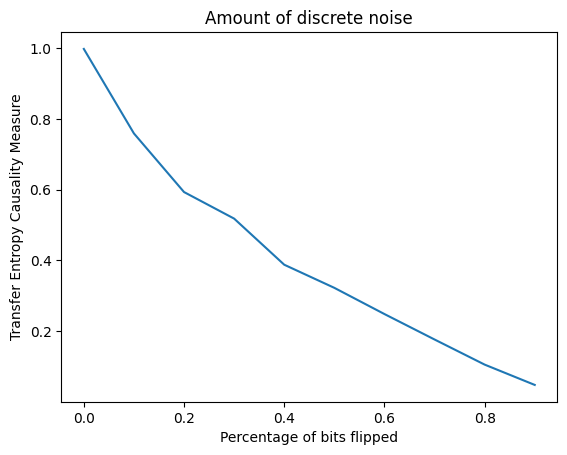

In [53]:
# random bitstring of length 12000
import random
import matplotlib.pyplot as plt

def generate_error(noise):
  bit_str = ""

  for i in range(2000):
    bit_str += str(random.randint(0,1))

  bit_str_shift = bit_str[1:] + str(0)

  a = bit_str
  b = ""

  for i in range(len(bit_str_shift)):
    # flip 10% of bits
    if (random.uniform(0,1) < noise):
      if bit_str_shift[i] == 0:
        b += str(1)
      else:
        b += str(0)
    else:
      b += bit_str_shift[i]


  a = [*a]
  b = [*b]

  for i in range(len(a)):
    a[i] = int(a[i])
    b[i] = int(b[i])

  return pyinform.transfer_entropy(b, a, k=3)

tes= [generate_error(x) for x in np.arange(0,1,0.1)]
plt.plot(np.arange(0,1, 0.1), tes)
plt.title("Amount of discrete noise")
plt.xlabel("Percentage of bits flipped")
plt.ylabel("Transfer Entropy Causality Measure")
plt.show()


# Anant Code

In [ ]:
# Anant Code

# -*- coding: utf-8 -*-
"""
Created on Mon Jun 13 10:52:02 2022

@author: anant
"""

import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.integrate import odeint, solve_ivp
import pandas as pd
import math
import sdeint

class DataGenerator():

    def __init__(self, fun, data=None, sigma = 0, **kwargs):
        self.func = fun
        self.kwargs = kwargs
        self.data = data
        self.sigma = sigma

    def noise(self,arr):
        if(self.sigma == 0):
            return arr
        noise = arr+ np.random.normal(0, self.sigma, len(arr))
        return noise

    def lorenz96(x, t):
        p = len(x)
        globF = 10
        def gt():
            GC = np.zeros((p, p), dtype=int)
            for i in range(p):
                GC[i, i] = 1
                GC[i, (i + 1) % p] = 1
                GC[i, (i - 1) % p] = 1
                GC[i, (i - 2) % p] = 1
            return GC

        def lorenz(x,t, *args):
            d = np.zeros(p)
            # Loops over indices (with operations and Python underflow indexing handling edge cases)
            F = args[0] if len(args) > 0 else globF
            for i in range(p):
                d[i] = (x[(i + 1) % p] - x[i - 2]) * x[i - 1] - x[i] + F
            return d
        return lorenz, gt

    def chua(x,t):
        p = len(x)
        assert p == 3
        def gt():
            return np.array([[1,1,0],
                             [1,1,1],
                             [1,1,1]])
        def fun(x,t, *args):
            d = np.zeros(p)
            # Loops over indices (with operations and Python underflow indexing handling edge cases)
            a,b,c, k = 1.3, .11, 7, 0
            alpha, beta = args if len(args) > 0 else 10.82, 14.286
            h = -b*math.sin(math.pi*x[0]/(2*a) +k )
            d[0] = alpha*(x[1] - h)
            d[1] = x[0] - x[1] + x[2]
            d[2] = -beta*x[1]
            return d
        return fun, gt

    def lotka_volterra(x, t):
        N = len(x)
        halfN = N//2
        numcomp = 2
        if((N/2) % numcomp != 0):
            raise ValueError("Half of num variables must be multiple of num competitors")
        def gt():
            init = np.zeros((N,N))
            for i in range(N):
                init[i,i]=1
                compstart = ((i//numcomp)*numcomp + halfN)%N
                init[i,compstart:compstart+numcomp ] = 1
            return init
        def funcint(x, t, *args):
            alpha, beta, delta, gamma = args
            dx = np.zeros(halfN)
            dy = np.zeros(halfN)
            xi = x[:halfN]
            yi = x[halfN:]
            for i in range(halfN):
                compstart = ((i//numcomp)*numcomp + halfN)%N
                xcomps = yi[compstart:compstart+numcomp]
                dx[i] = alpha*xi[i] - beta*xi[i]*sum(xcomps) - alpha*(xi[i]/200)**2
                ycomps = xi[compstart:compstart+numcomp]
                dy[i] = delta*yi[i]*sum(ycomps) - gamma*yi[i]
            return np.concatenate((dx, dy))
        return funcint, gt

    def add_gaussian_noise_post(data, perc, channels = None):
        if channels == None:
            channels = range(len(data[0]))
        retData = np.copy(data)
        size = len(retData)
        sigma = np.std(retData, axis=0)
        for i, channel in enumerate(channels):
            retData[:,channel] += np.random.normal(0, sigma[i]*perc, size = size)
        return retData

    def normalize(data):
        m = np.mean(data, axis = 0)
        s = np.std(data, axis=0)
        return (data-m)/s

    def integrate(self, p, T, delta_t=0.01, sd=0.1, burn_in=1000,
                       seed=0, args = ()):
        if seed is not None:
            np.random.seed(seed)

        # if(self.func.__name__ == "lotka_volterra"):
        #     alpha, beta, delta, gamma = args
        #     gen = MultiLotkaVolterra(p=p//2, d=2, alpha=alpha, beta=beta, delta=delta, gamma=gamma, sigma=self.sigma)
        #     series, graph, _ = gen.simulate(int((T+burn_in)/delta_t), dt = delta_t)
        #     X = series[0]
        #     return X[burn_in:], graph
        # Use scipy to solve ODE.
        x0 = np.random.uniform(low = -0.1, high = 0.1, size=p) + args[0]
        t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
        funcint, ground_truth = self.func(x0,t)
        def noisearr(x,t,*args):
            return np.diag(self.sigma*np.ones(p))
        X = sdeint.itoint(funcint, noisearr, x0, t)
        X = DataGenerator.normalize(X)
        return X[burn_in:], ground_truth()

    def simulate(self, p, T, delta_t=0.01, sd=0.1, burn_in=1000,
                       seed=0, args = (10,)):
        if seed is not None:
            np.random.seed(seed)

        # Use scipy to solve ODE.
        x0 = np.random.uniform(low = -0.1, high = 0.1, size=p) + args[0]
        t = np.linspace(0, (T + burn_in) * delta_t, T + burn_in)
        tf = (T + burn_in) * delta_t
        funcint, ground_truth = self.func(x0,t)
        X = odeint(funcint, x0, t, args= args)
        #X2 = np.transpose(solve_ivp(funcint3, (0, tf), x0, t_eval=t, args=args)['y'])
        #X += np.random.normal(scale=sd, size=(T + burn_in, p))
        X = DataGenerator.normalize(X)
        return X[burn_in:], ground_truth()

    def csv_to_graph(gtfile, N):
        """Collects the total delay of indirect causal relationships."""
        gtdata = pd.read_csv(gtfile, header=None)
        ret = np.zeros((N,N))
        effects = gtdata[1]
        causes = gtdata[0]

        for i in range(len(effects)):
            key=effects[i]
            value=causes[i]
            ret[key][value] = 1
        return ret

    def finance(file, gtfile = None):
        x = pd.read_csv(file, index_col = False)
        if("Date" in list(x.columns)):
            x = x.drop(columns = ["Date"])
        x = x.values
        if(gtfile == None):
            return x, gtfile
        gt = DataGenerator.csv_to_graph(gtfile, x.shape[1])
        return x, gt



if(__name__ == "__main__"):
    # lorenz_generator = DataGenerator(DataGenerator.lorenz96_func)
    # series = lorenz_generator.create_series([[0.64994384, 0.01750787, 0.72402577, 0.14358566, 0.502893]], F = 8)
    # lorenz_generator.ApEn_data(data = np.random.normal(20, 2, size = 20))
    lorenz_generator = DataGenerator(DataGenerator.lorenz96)

In [ ]:
lorenz_generator = DataGenerator(DataGenerator.lorenz96)

In [ ]:
lorenz_generator.simulate(p = 20, T = 10)

(array([[ 1.01296777e+00, -9.94941847e-01, -1.14761287e+00,
         -2.19795862e+00,  1.36711109e+00,  1.06142010e+00,
         -8.05506677e-01, -3.20568794e-01,  4.71379636e-01,
          1.21897534e+00, -9.20448810e-01, -3.70438197e-01,
          9.57781123e-01, -4.38832088e-01, -6.69475026e-01,
         -1.06365255e+00, -9.26768315e-02,  5.71987099e-01,
         -1.46135746e+00,  3.02912017e-02],
        [ 1.02754082e+00, -1.07896991e+00, -1.06435257e+00,
         -2.26589946e+00,  1.19905903e+00,  1.23443805e+00,
         -9.11520881e-01, -3.03498908e-01,  5.17385660e-01,
          1.18806370e+00, -9.77360168e-01, -3.46859895e-01,
          9.68027594e-01, -4.42275079e-01, -6.56361844e-01,
         -1.04303091e+00, -1.00730662e-01,  5.61853913e-01,
         -1.44373337e+00,  2.53543466e-02],
        [ 1.03977767e+00, -1.15422893e+00, -9.69224436e-01,
         -2.31695315e+00,  1.02316747e+00,  1.38679270e+00,
         -1.01141370e+00, -2.83850330e-01,  5.65758511e-01,
          1.

In [ ]:
# Code for Actually Implementing TE

In [ ]:
!pip install pyinform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 3.2 MB/s eta 0:00:00


In [ ]:
pyinform.transferentropy.transfer_entropy(source, target, k, condition=None, local=False)[source]

ok, so ome fun stuff from the textbook

In [ ]:
# TransferEntropy.R
library(IDPmisc)
library(quantmod)
library(RTransferEntropy)
library(future)

### Apply function D.Func to all pairwise combinations of the data.frame X
### Returns a matrix: output[a,b] = D.Func(X[,a], X[,b])
FApply.Pairwise <- function(X, D.Func){
  n = seq_len(ncol(X))

  ff.TE.value = function(a, b) D.Func(X[,a], X[,b])

  return(outer(n, n, Vectorize(ff.TE.value)))
}


Linear.GC <- function(X, Y){

  n<-length(X)
  X.now<-X[1:(n-1)]
  Y.now<-Y[1:(n-1)]
  Y.fut<-Y[2:n]

  regression.uni=lm(Y.fut~Y.now)
  regression.mult=lm(Y.fut~Y.now+ X.now)
  var.eps.uni <- (summary(regression.uni)$sigma)^2
  var.eps.mult <- (summary(regression.mult)$sigma)^2
  GC <- log(var.eps.uni/var.eps.mult)
  return(GC)

}




######## Simulated systems

n.points<-10000
x1<-x2<-x3<-x4<-x5<-vector()
x1[1]<-x2[1]<-x3[1]<-x4[1]<-x5[1]<-0
w1<-rnorm(n.points,0,1)
w2<-rnorm(n.points,0,1)
w3<-rnorm(n.points,0,1)
w4<-rnorm(n.points,0,1)
w5<-rnorm(n.points,0,1)
################ LINEAR
for(i in 2:(n.points)){
  x1[i] <- 0.95*sqrt(2)*x1[i-1] - 0.9025*x1[i-1] + w1[i]
  x2[i] <- 0.5*(x1[i-1]) + w2[i]
  x3[i] <- -0.4*x1[i-1] + w3[i]
  x4[i] <- -0.5*(x1[i-1]) + 0.25*sqrt(2)*x4[i-1] + 0.25*sqrt(2)*x5[i-1] + w4[i]
  x5[i] <- -0.25*sqrt(2)*(x4[i-1]) + 0.25*sqrt(2)*x5[i-1] + w5[i]
}
x1 <- x1[-1]
x2 <- x2[-1]
x3 <- x3[-1]
x4 <- x4[-1]
x5 <- x5[-1]

linear.system <- data.frame(x1, x2, x3, x4, x5)

TE.matrix1<-FApply.Pairwise(linear.system, calc_te)
TE.matrix2<-FApply.Pairwise(linear.system, Linear.GC)
rownames(TE.matrix1)<-colnames(TE.matrix1)<-var.names<-c("x1", "x2", "x3", "x4", "x5")
rownames(TE.matrix2)<-colnames(TE.matrix2)<-var.names<-c("x1", "x2", "x3", "x4", "x5")
corrplot::corrplot(corr = TE.matrix1, diag = FALSE,
                   is.corr = FALSE, outline = T,tl.col = "black",
                   method = "color",
                   col = colorRampPalette(c("blue","white", "red"))(100))

corrplot::corrplot(corr = TE.matrix2, diag = FALSE,
                   is.corr = FALSE, outline = T,tl.col = "black",
                   method = "color",
                   col = colorRampPalette(c("blue","white", "red"))(100))

library(future)
## Allow for parallel computing
plan(multiprocess)
transfer_entropy(x4, x5)

###### Global Market Indices

#https://finance.yahoo.com/world-indices/
tickers<-c("^GSPC", "^FTSE", "^GDAXI", "^N100", "^BVSP")

data.env <- new.env()
dataset<- xts() # Only run once


# Download prices from AlphaVantage and calculate log-returns
for(i in 1:length(tickers)) {
  tickers[i]-> symbol
  print(symbol)
  getSymbols(symbol, src="av",
             auto.assign=TRUE,
             output.size="full",
             adjusted=TRUE,
             api.key=config::get()$alpha.vantage.key)

    dataset <- merge(dataset, periodReturn(Ad(get(tickers[i])),period="daily", type='log'))
    rm(symbol)
}

names(dataset)<-tickers
write.csv(dataset, file="./data/global_indices_returns.csv", row.names = TRUE, )
tmp <- tempfile()
write.zoo(dataset,sep=",",file="./data/global_indices_returns.csv")

dataset.post.crisis <- NaRV.omit(as.data.frame(dataset["2014-01-01/"]))


## Allow for parallel computing
plan(multiprocess)
# Calculate pairwise Transfer Entropy among global indices
TE.matrix<-FApply.Pairwise(dataset.post.crisis, calc_ete())
rownames(TE.matrix)<-colnames(TE.matrix)<-tickers

corrplot::corrplot(corr = TE.matrix/max(TE.matrix), diag = FALSE, order = "hclust", is.corr = FALSE)


dataset2<-read.zoo('./data/global_indices_returns.csv',
                  header=TRUE,
                  index.column=1, sep=",")